In [2]:
from google.colab import files

uploaded = files.upload()  # This will open a file upload prompt


Saving SMSSpamCollection to SMSSpamCollection


In [3]:
import os

print(os.listdir())  # Should show 'sms_spam.csv'


['.config', 'SMSSpamCollection', 'sample_data']


In [4]:
# %matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle # Changed cPickle to pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
# GridSearchCV has been moved to model_selection
from sklearn.model_selection import GridSearchCV
# The following imports are deprecated in newer versions of scikit-learn.
# Replace them with the updated imports below.
# from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
# from sklearn.learning_curve import learning_curve
from sklearn.model_selection import learning_curve # Updated import for learning_curve

In [5]:
messages = [line.rstrip() for line in open('./SMSSpamCollection')]
print(len(messages))

5574


In [6]:
for message_no, message in enumerate(messages[:10]):
    print (message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

In [7]:

messages = pandas.read_csv('./SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5569  spam  This is the 2nd time we have tried 2 contact u...
5570   ham               Will ü b going to esplanade fr home?
5571   ham  Pity, * was in mood for that. So...any other s...
5572   ham  The guy did some bitching but I acted like i'd...
5573   ham                         Rofl. Its true to its name

[5574 rows x 2 columns]


In [8]:
messages.groupby('label').describe()


message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [9]:

messages['length'] = messages['message'].map(lambda text: len(text))
print(messages.head())

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


In [10]:
messages.length.describe()


,length
count,5574.000000
mean,80.478292
std,59.848302
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


In [11]:
print (list(messages.message[messages.length > 900]))


["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

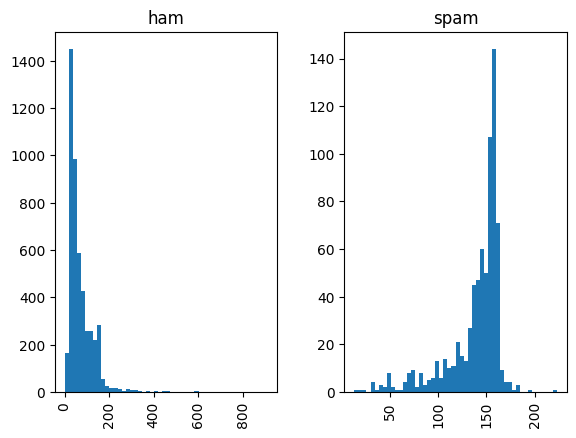

In [12]:
messages.hist(column='length', by='label', bins=50)


In [13]:
messages


,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,160
5570,ham,Will ü b going to esplanade fr home?,36
5571,ham,"Pity, * was in mood for that. So...any other s...",57
5572,ham,The guy did some bitching but I acted like i'd...,125


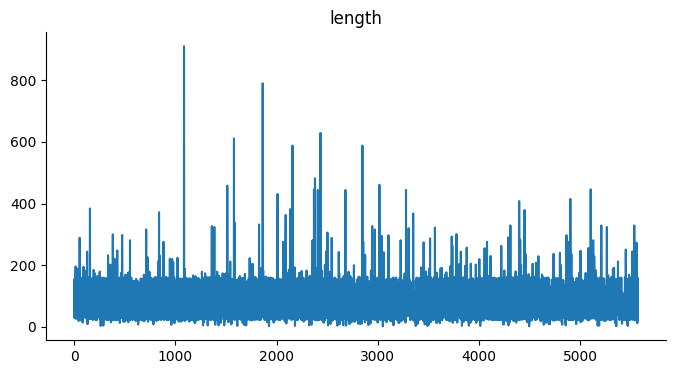

In [21]:

from matplotlib import pyplot as plt
messages['length'].plot(kind='line', figsize=(8, 4), title='length')
plt.gca().spines[['top', 'right']].set_visible(False)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_data(file_path):
    """
    Load the SMS dataset from a given file path.
    Expected format: CSV with 'label' and 'message' columns.
    """
    df = pd.read_csv(file_path, encoding='latin-1')
    df = df.rename(columns={"v1": "label", "v2": "message"})  # Adjust column names if necessary
    return df

def preprocess_data(df):
    """
    Convert labels to binary (spam=1, ham=0) and clean the data if necessary.
    """
    df["label"] = df["label"].map({"ham": 0, "spam": 1})  # Convert labels to binary
    df = df[["label", "message"]]  # Keep only necessary columns
    return df

def split_and_save_data(df, train_path="train.csv", val_path="validation.csv", test_path="test.csv"):
    """
    Split the dataset into train (70%), validation (15%), and test (15%) sets.
    """
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])

    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    test_df.to_csv(test_path, index=False)

    return train_df, val_df, test_df


df = messages
train_df, val_df, test_df = split_and_save_data(df)
print("Data preparation complete. Files saved as train.csv, validation.csv, and test.csv.")


Data preparation complete. Files saved as train.csv, validation.csv, and test.csv.
